In [1]:
import os
import pysam
import numpy as np
import pandas as pd
import pickle

from collections import OrderedDict

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
proj_data_dir = '/zfssz6/ST_MCHRI/BIGDATA/P18Z10200N0124/NIPT_CNV'

onek_ds_bam_dir =os.path.join(proj_data_dir,'final_file')
ref_fa_f = '/zfssz6/ST_MCHRI/BIGDATA/database/BGI-seq500_OSS_download/human_reference/hg38/Homo_sapiens_assembly38.fasta'
ref_map_f = '/zfssz6/ST_MCHRI/BIGDATA/P18Z10200N0124/NIPT_CNV/NIPT_CNV/NIPT_35bp_hg38_map_gc/Homo_sapiens_assembly38.fasta.kmer35.bw'

# NA12878 CNVs data
sampleId = 'NA12878'
fcnv_fname = os.path.join(proj_data_dir,'NIPT_CNV/'+sampleId+'.ge1k.af0_05.cnvs.dat.pkl')


In [4]:
# load NA12878 cnvs
with open(fcnv_fname, 'rb') as f:
    cnvs_dict = pickle.load(f)

# load bam file and fasta file
sample_id_arr = np.loadtxt(os.path.join(proj_data_dir,'sample.list'), 
                        delimiter='\t',usecols=(0,1),dtype='str')

sample_id_dict=dict(zip(sample_id_arr[:,0],sample_id_arr[:,1]))

bamfile =  pysam.AlignmentFile(os.path.join(onek_ds_bam_dir,
                                           sampleId+'/'+sample_id_dict[sampleId]+\
                                            '.sorted.rmdup.realign.BQSR.bam'), 
                               mode='rb')#,reference_filename=ref_fa_f)
reffile =  pysam.FastaFile(ref_fa_f) 


In [11]:
os.path.join(onek_ds_bam_dir, sampleId+'/'+sample_id_dict[sampleId]+'.sorted.rmdup.realign.BQSR.bam')

'/zfssz6/ST_MCHRI/BIGDATA/P18Z10200N0124/NIPT_CNV/final_file/NA12878/SRR098401_1.sorted.rmdup.realign.BQSR.bam'

In [5]:
# chr_name
chr_id = '22'

In [6]:
# creat features
# runing slow
from collections import Counter
import pyBigWig

feat_dict={}
feat_dict[chr_id]={}

filed_name1 = 'mapped_pos_seq_base_cov' #
filed_name2 = 'mapped_pos_seq_mean_base_seq_qual'
filed_name3 = 'mapped_pos_seq_mean_base_map_qual'
filed_name4 = 'mapped_pos_seq_base_gc_cnts'

filed_name5 = 'mapped_pos_seq_a_cnt'
filed_name6 = 'mapped_pos_seq_t_cnt'
filed_name7 = 'mapped_pos_seq_c_cnt'
filed_name8 = 'mapped_pos_seq_g_cnt'

filed_name9 = 'ref_bases'
filed_name10 = 'ref_mappability'

# creat dict for saving features
d1=OrderedDict()
d2=OrderedDict()
d3=OrderedDict()
d4=OrderedDict()

d5=OrderedDict()
d6=OrderedDict()
d7=OrderedDict()
d8=OrderedDict()

its=bamfile.pileup('chr'+ chr_id,stepper='nofilter',min_base_quality=0) 
# Coordinates in pysam are always 0-based (following the python convention). SAM text files use 1-based coordinates.
for pileupcolumn in its: 
    # each iteration return a PileupColumn Object which represents all the reads in the bam files that
    # map to a single base in the reference sequence. The list of reads are represented as PileupRead objects 
    # in the PileupColumn.pileups property.
    d1[pileupcolumn.reference_pos]=pileupcolumn.get_num_aligned() # base coverage
    d2[pileupcolumn.reference_pos]=np.mean(pileupcolumn.get_query_qualities()) # base quality
    d3[pileupcolumn.reference_pos]=np.mean(pileupcolumn.get_mapping_qualities()) # base mappablity 
    
    i_seq = [x.upper() for x in pileupcolumn.get_query_sequences()]#(mark_matches=True, mark_ends=True,add_indels=True)] 
    i_read_bases_cnt = Counter(i_seq)
    
    d4[pileupcolumn.reference_pos]=i_read_bases_cnt.get('G',0) + i_read_bases_cnt.get('C',0)    
    
    d5[pileupcolumn.reference_pos]=i_read_bases_cnt.get('A',0)
    d6[pileupcolumn.reference_pos]=i_read_bases_cnt.get('T',0)
    d7[pileupcolumn.reference_pos]=i_read_bases_cnt.get('C',0)
    d8[pileupcolumn.reference_pos]=i_read_bases_cnt.get('G',0)

feat_dict[chr_id][filed_name1]=d1
feat_dict[chr_id][filed_name2]=d2
feat_dict[chr_id][filed_name3]=d3
feat_dict[chr_id][filed_name4]=d4

feat_dict[chr_id][filed_name5]=d5
feat_dict[chr_id][filed_name6]=d6
feat_dict[chr_id][filed_name7]=d7
feat_dict[chr_id][filed_name8]=d8

# reference gc 
ref_basegc_enc = [x.upper() for x in reffile.fetch('chr'+ chr_id)]
chr_len = len(ref_basegc_enc)
feat_dict[chr_id][filed_name9]=OrderedDict(zip(range(chr_len),ref_basegc_enc))

# reference mappabillity
with pyBigWig.open(ref_map_f,'r') as bw:
    feat_dict[chr_id][filed_name10]=OrderedDict(zip(range(chr_len),bw.values('chr'+ chr_id,0,chr_len-1)))

del d1
del d2
del d3
del d4
del d5
del d6
del d7
del d8


In [12]:
# load cnvs
chr_cnvs_df = cnvs_dict[chr_id]
chr_tu = zip(chr_cnvs_df['POS'].values,chr_cnvs_df['END'].values,chr_cnvs_df['ADJTYPE'].values)

feats_pos = np.array(list((feat_dict[chr_id][filed_name1].keys())))
feats1 = np.array(list((feat_dict[chr_id][filed_name1].values())))
feats2 = np.array(list((feat_dict[chr_id][filed_name2].values())))
feats3 = np.array(list((feat_dict[chr_id][filed_name3].values())))
feats4 = np.array(list((feat_dict[chr_id][filed_name4].values())))

feats5 = np.array(list((feat_dict[chr_id][filed_name5].values())))
feats6 = np.array(list((feat_dict[chr_id][filed_name6].values())))
feats7 = np.array(list((feat_dict[chr_id][filed_name7].values())))
feats8 = np.array(list((feat_dict[chr_id][filed_name8].values())))

feats9 = np.array(list((feat_dict[chr_id][filed_name9].values()))) # bases on reference
feats10 = np.array(list((feat_dict[chr_id][filed_name10].values())))


m_feat = 13-4
# only consider the mappped position
cnvs_feats={}
cnvs_feats[chr_id]=[]
for start,end,ty in chr_tu:
    i_idx = (feats_pos>=start) & (feats_pos<=end)
    f_pos = feats_pos[i_idx]
    
    f_mat = np.zeros((m_feat,len(f_pos)))
    f_mat[0]=feats1[i_idx]
    f_mat[1]=feats2[i_idx]
    f_mat[2]=feats3[i_idx]
    f_mat[3]=feats4[i_idx]
    
    f_mat[4]=feats5[i_idx]
    f_mat[5]=feats6[i_idx]
    f_mat[6]=feats7[i_idx]
    f_mat[7]=feats8[i_idx]
    f_mat[8]=feats10[f_pos]
    
#     for m,f_base in enumerate(feats9[f_pos]):
#         if f_base.upper()=='A':
#             f_mat[8,m]=1
#         elif f_base.upper()=='T':
#             f_mat[9,m]=1
#         elif f_base.upper()=='C':
#             f_mat[10,m]=1
#         elif f_base.upper()=='G':
#             f_mat[11,m]=1
    
    cnvs_feats[chr_id].append((start,end,ty,f_mat))
    

In [13]:
for nn in cnvs_feats[chr_id]:
    f_mat = nn[3]
    print('cov,base_qual,map_qual,mappability')
    print(np.max(f_mat[0]),np.max(f_mat[1]),np.max(f_mat[2]),np.max(f_mat[12]))

cov,base_qual,map_qual,mappability


IndexError: index 12 is out of bounds for axis 0 with size 9

<Figure size 1440x1440 with 0 Axes>

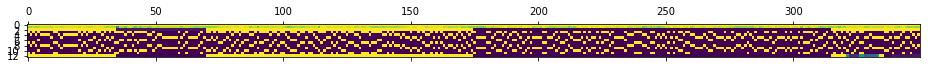

In [43]:
import matplotlib.cm as cm
plt.figure(figsize=(20,20))
f_mat = cnvs_feats[chr_id][1][3]
f_mat = f_mat/np.max(f_mat,axis=1).reshape((13,1))
plt.matshow(f_mat)

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x1440 with 0 Axes>

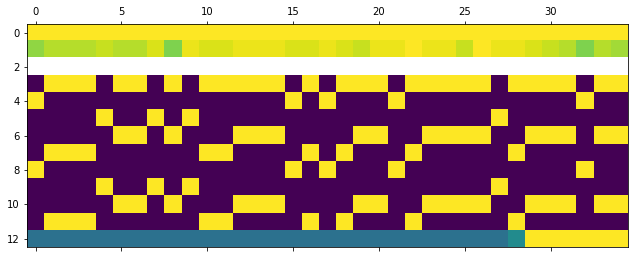

In [44]:
plt.figure(figsize=(20,20))
f_mat = cnvs_feats[chr_id][0][3]
f_mat = f_mat/np.max(f_mat,axis=1).reshape((13,1))
plt.matshow(f_mat)

In [29]:
base_x = np.array(list(feat_dict[chr_id][filed_name1].keys()))
base_y = np.array(list(feat_dict[chr_id][filed_name1].values()))


In [46]:
base_x[:50]

array([10510562, 10510563, 10510564, 10510565, 10510566, 10510567,
       10510568, 10510569, 10510570, 10510571, 10510572, 10510573,
       10510574, 10510575, 10510576, 10510577, 10510578, 10510579,
       10510580, 10510581, 10510582, 10510583, 10510584, 10510585,
       10510586, 10510587, 10510588, 10510589, 10510590, 10510591,
       10510592, 10510593, 10510594, 10510595, 10510596, 10511428,
       10511429, 10511430, 10511431, 10511432, 10511433, 10511434,
       10511435, 10511436, 10511437, 10511438, 10511439, 10511440,
       10511441, 10511442])

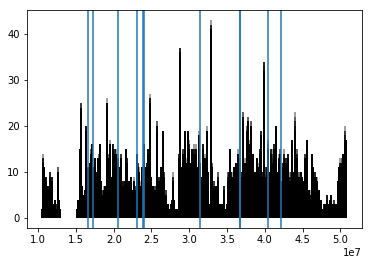

In [15]:
plt.figure(figsize=(20,6))
plt.vlines(x=base_x, ymin=0, ymax=base_y)
chr_cnvs_tu=zip(chr_cnvs_df['POS'].values, chr_cnvs_df['END'].values, chr_cnvs_df['ADJTYPE'].values)
for start,end,ty in chr_cnvs_tu:
    if ty=='DEL':
        plt.axvline(x=start,c='r')
    else ty=='DUP':
        plt.axvline(x=start,c='b')

17289393


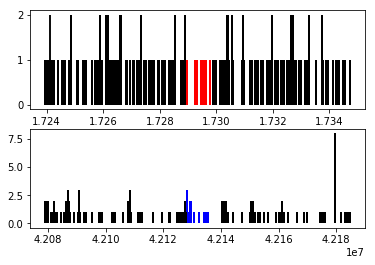

In [44]:

fig, axs = plt.subplots(2, 1)
pads = 50000
del_plt = False
dup_plt = False
chr_cnvs_tu=zip(chr_cnvs_df['POS'].values, chr_cnvs_df['END'].values, chr_cnvs_df['ADJTYPE'].values)
for start,end,ty in chr_cnvs_tu:
    if end-start<5000:
        continue
    
    if ty=='DEL' and not del_plt:
        del_base_x = base_x[(base_x>=start) & (base_x<=end)]
        del_base_y = base_y[(base_x>=start) & (base_x<=end)]
        axs[0].vlines(x=del_base_x, ymin=0, ymax=del_base_y, colors='r')
        
        del_base_x_before = base_x[(base_x>=start-pads) & (base_x<start)]
        del_base_y_before = base_y[(base_x>=start-pads) & (base_x<start)]
        axs[0].vlines(x=del_base_x_before, ymin=0, ymax=del_base_y_before, colors='k')
        
        del_base_x_end = base_x[(base_x>end) & (base_x<=end+pads)]
        del_base_y_end = base_y[(base_x>end) & (base_x<=end+pads)]
        
        axs[0].vlines(x=del_base_x_end, ymin=0, ymax=del_base_y_end, colors='k')
        
        
        del_plt=True
        
    if ty=='DUP' and not dup_plt:
        
        dup_base_x = base_x[(base_x>=start) & (base_x<=end)]
        dup_base_y = base_y[(base_x>=start) & (base_x<=end)]
        axs[1].vlines(x=dup_base_x, ymin=0, ymax=dup_base_y, colors='b')
        
        dup_base_x_before = base_x[(base_x>=start-pads) & (base_x<start)]
        dup_base_y_before = base_y[(base_x>=start-pads) & (base_x<start)]
        axs[1].vlines(x=dup_base_x_before, ymin=0, ymax=dup_base_y_before, colors='k')
        
        dup_base_x_end = base_x[(base_x>end) & (base_x<=end+pads)]
        dup_base_y_end = base_y[(base_x>end) & (base_x<=end+pads)]
        
        axs[1].vlines(x=dup_base_x_end, ymin=0, ymax=dup_base_y_end, colors='k')
        
        dup_plt = True

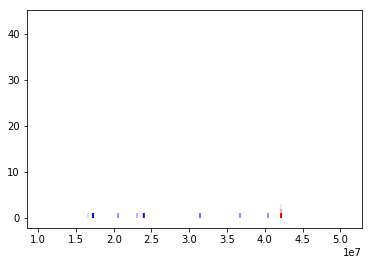

In [14]:
colors=['r', 'b','k']
legends=['DUP','DEL', 'NEU']
alphas = [1,1,0.01]

for i,clr in enumerate(colors):
    i_x = base_x[colr==clr]
    i_y = base_y[colr==clr]
    plt.vlines(x=i_x, ymin=0, ymax=i_y, alpha = alphas[i], colors = clr,linewidth=0.01)



KeyboardInterrupt: 

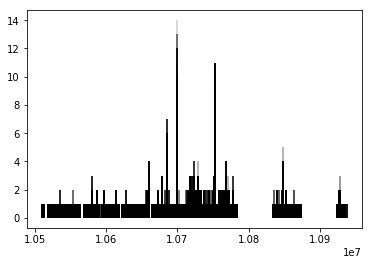

In [9]:
for i,(al,clr) in enumerate(zip(tran,colr)):
    plt.vlines(x=base_x[i], ymin=0, ymax=base_y[i], alpha = al, colors = clr)

In [ ]:
len(base_y)

In [ ]:
its=bamfile.pileup('chr22')
for pileupcolumn in its:
    print ("\ncoverage at base %s = %s, %s" %
           (pileupcolumn.pos, pileupcolumn.n,pileupcolumn.get_num_aligned()))
    for pileupread in pileupcolumn.pileups:
        if not pileupread.is_del and not pileupread.is_refskip:
            # query position is None if is_del or is_refskip is set.
            print ('\tbase in read %s = %s' %
                  (pileupread.alignment.query_name,
                   pileupread.alignment.query_sequence[pileupread.query_position]))

In [1]:

# bamfile.close()

In [ ]:
bamfile.close()
reffile.close()

In [39]:
import collections
d={
    "Apple": 5,
    "Banana": 95,
    "Orange": 2,
    "Mango": 7
}
# sorted the dictionary by value using OrderedDict
od = collections.OrderedDict(d)
print(od)
# OrderedDict([('Orange', 2), ('Apple', 5), ('Mango', 7), ('Banana', 95)])
sorted_fruit_list = list(od.keys())
print(sorted_fruit_list)

OrderedDict([('Apple', 5), ('Banana', 95), ('Orange', 2), ('Mango', 7)])
['Apple', 'Banana', 'Orange', 'Mango']


In [41]:
val = od.values()
val

odict_values([5, 95, 2, 7])